# Tutorial2: Analyzing GAN Geometry and Explore the Axes
This basically correspond to Figure 2 and 3.

First let's sample more points and collects more metric tensors.

In [1]:
import os
from os.path import join
from tqdm import tqdm
from time import time
import numpy as np
import torch
import matplotlib.pylab as plt
from core import get_full_hessian, hessian_compute, save_imgrid, show_imgrid, plot_spectra, hessian_summary_pipeline
from core.GAN_utils import DCGAN_wrapper, loadDCGAN, BigGAN_wrapper, loadBigGAN, upconvGAN
import lpips
ImDist = lpips.LPIPS(net="squeeze", )

Setting up [LPIPS] perceptual loss: trunk [squeeze], v[0.1], spatial [off]
Loading model from: C:\Users\binxu\.conda\envs\tf\lib\site-packages\lpips\weights\v0.1\squeeze.pth


Let's take the simplest model DCGAN (trained on fashion dataset) and analyze its geometry!

In [2]:
DG = loadDCGAN()
DG.cuda().eval()
DG.requires_grad_(False)
G = DCGAN_wrapper(DG)

Using cache found in C:\Users\binxu/.cache\torch\hub\facebookresearch_pytorch_GAN_zoo_hub


Average network found !


Get some coffee and run Hessian computation at multiple points in the latent space! (Using BackProp method, it takes around 270 secs for 30 different points.)

In [4]:
trials = 30
savedir = join("hessian\\DCGAN")
os.makedirs(savedir, exist_ok=True)

In [ ]:
T0 = time()
for triali in tqdm(range(trials)):
    feat = G.sample_vector(sampn=1)  #.detach().clone().cuda()
    eva_BP, evc_BP, H_BP = hessian_compute(G, feat, ImDist, hessian_method="BP")
    #eva_FI, evc_FI, H_FI = hessian_compute(G, feat, ImDist, hessian_method="ForwardIter", EPS=1E-4)
    np.savez(join(savedir, "Hess_BP_%d.npz" % triali), eva_BP=eva_BP, evc_BP=evc_BP, H_BP=H_BP, feat=feat.cpu().detach().numpy())
print("Total time %.2f sec"%(time() - T0))

Now plot summary statistics on the hessians you computed:

* Distribution of spectra at different points
* Hessian consistency across points
* Examples of Hessian correlation at 3 points or 5 points

30it [00:00, 577.26it/s]
100%|██████████| 30/30 [00:00<00:00, 75.61it/s]


Load 30 npz files of Hessian info
1.1 sec
Compute results saved to hessian\DCGAN\summary\Hess_DCGAN_corr_mat.npz
Log scale non-diag mean corr value 0.952 med 0.954
Lin scale non-diag mean corr value 0.739 med 0.777
0.4 sec
Compute results saved to hessian\DCGAN\summary\Hess_DCGAN_corr_mat_vec.npz
Log scale non-diag mean corr value 0.952
Lin scale non-diag mean corr value 0.739


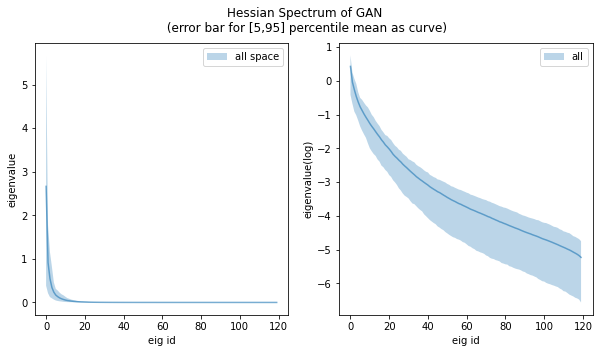

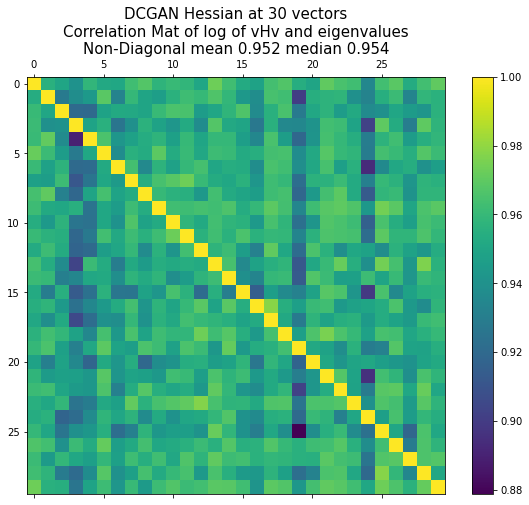

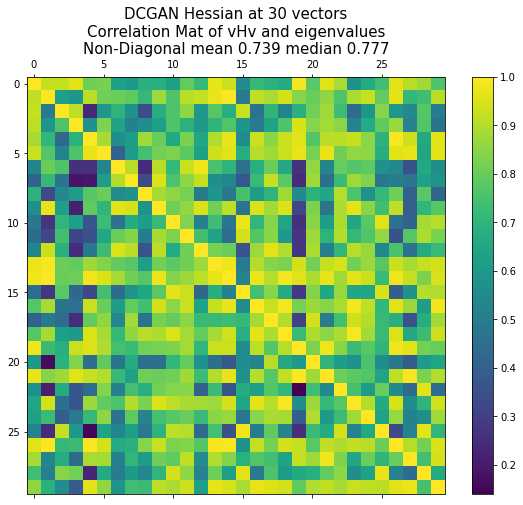

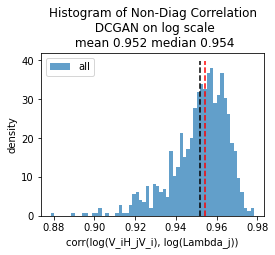

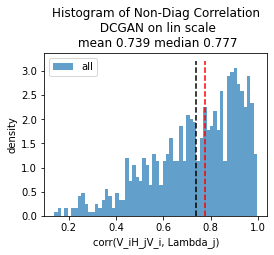

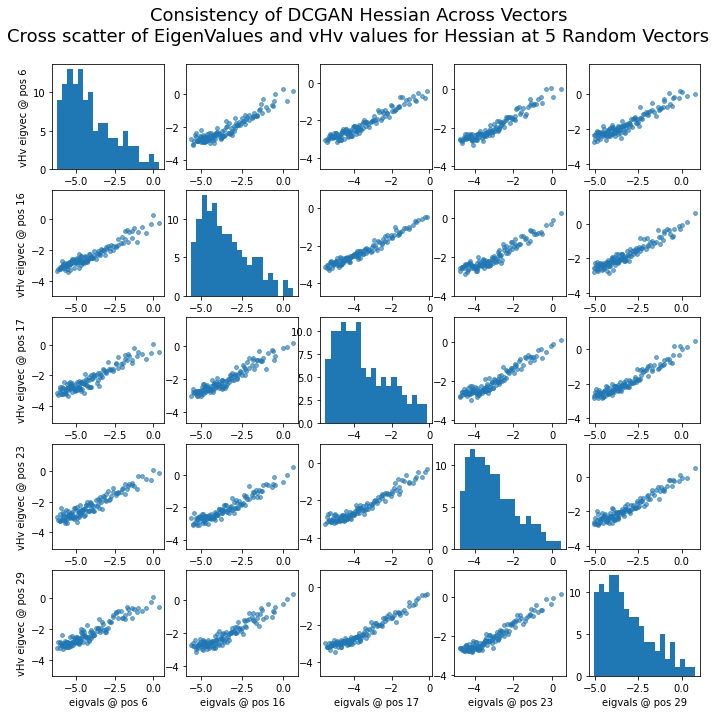

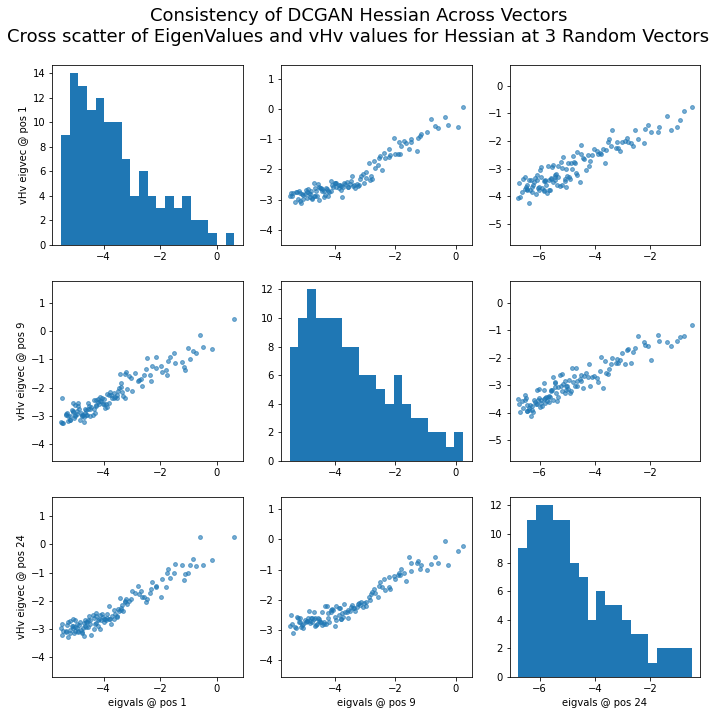

In [5]:
sumdir = join("hessian\\DCGAN\\summary")
os.makedirs(sumdir, exist_ok=True)
S = hessian_summary_pipeline(savedir, "DCGAN", sumdir, npzpatt="Hess_BP_(\d*).npz", featkey="feat", evakey='eva_BP', evckey='evc_BP', )

Are the correlation or consistency of Hessian matrices are related to the distance structure of the reference vectors? Seems not!

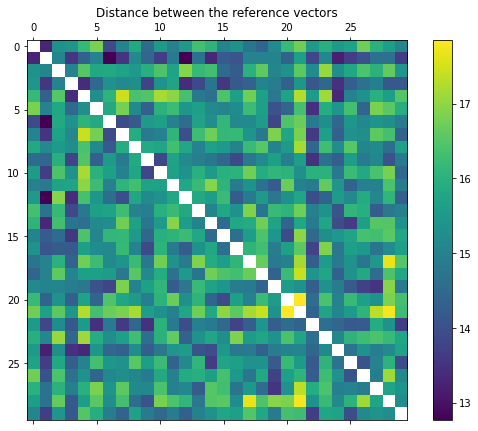

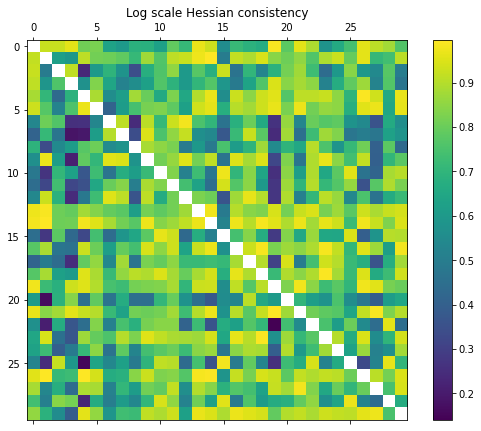

In [51]:
from scipy.spatial.distance import pdist, squareform
import numpy.ma as ma
distmat_feat = squareform(pdist(S.feat_col, metric="euclidean")) # cosine
distmat_feat += np.diag(np.nan * np.ones((distmat_feat.shape[0])))
plt.figure(figsize=[9,7])
plt.matshow(distmat_feat,fignum=0)
plt.title("Distance between the reference vectors")
plt.colorbar()
plt.show()
plt.figure(figsize=[9,7])
plt.matshow(S.corr_mat_lin,fignum=0)
plt.title("Log scale Hessian consistency")
plt.colorbar()
plt.show()

In [50]:
from scipy.stats import pearsonr
# cc = ma.corrcoef(ma.masked_invalid(S.corr_mat_lin.flatten()), ma.masked_invalid(distmat_feat.flatten()))[0,1]
msk = np.isnan(distmat_feat.flatten())
cval, pval = pearsonr(S.corr_mat_log.flatten()[~msk], distmat_feat.flatten()[~msk])
print("Pearson Corr of the distance between the feature tensor and the log Hessian consistency %.3f (P=%.1e)"%(cval, pval))
cval, pval = pearsonr(S.corr_mat_lin.flatten()[~msk], distmat_feat.flatten()[~msk])
print("Pearson Corr of the distance between the feature tensor and the lin Hessian consistency %.3f (P=%.1e)"%(cval, pval))

Pearson Corr of the distance between the feature tensor and the log Hessian consistency 0.088 (P=9.4e-03)
Pearson Corr of the distance between the feature tensor and the lin Hessian consistency 0.032 (P=3.4e-01)


## Mechanism behind the Geometry
How does this geometric structure comes into being? We can look into the architecture of the DCGAN model.
